In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import eotdl

eotdl.__version__

'2024.10.07'

In this notebook we generate the dataset for the use case

1. Generate list of Satellogic images to be used (containing bb and acquisition time)
2. Explore available S1/S2 images with different criteria
	- bounding box overlap
	- acquisition time overlap
3. Download matching S1/S2 at given resolution
4. Generate metadata and ingest to EOTDL 

In [60]:
import geopandas as gpd

gdf = gpd.read_parquet('data/satellogic-earthview-items.parquet')

gdf.head()

,json_path,zone,region,date,geometry
0,data/json/zone=04N/region=603411_2346301/date=...,04N,603411_2346301,2022-09-15,"POLYGON ((-157.99991 21.21181, -157.99988 21.2..."
1,data/json/zone=04N/region=603411_2346685/date=...,04N,603411_2346685,2022-09-15,"POLYGON ((-157.99988 21.21528, -157.99986 21.2..."
2,data/json/zone=04N/region=603411_2347069/date=...,04N,603411_2347069,2022-09-15,"POLYGON ((-157.99986 21.21875, -157.99984 21.2..."
3,data/json/zone=04N/region=603411_2347453/date=...,04N,603411_2347453,2022-09-15,"POLYGON ((-157.99984 21.22221, -157.99981 21.2..."
4,data/json/zone=04N/region=603411_2347837/date=...,04N,603411_2347837,2022-09-15,"POLYGON ((-157.99981 21.22568, -157.99979 21.2..."


In [61]:
gdf.shape

(7095985, 5)

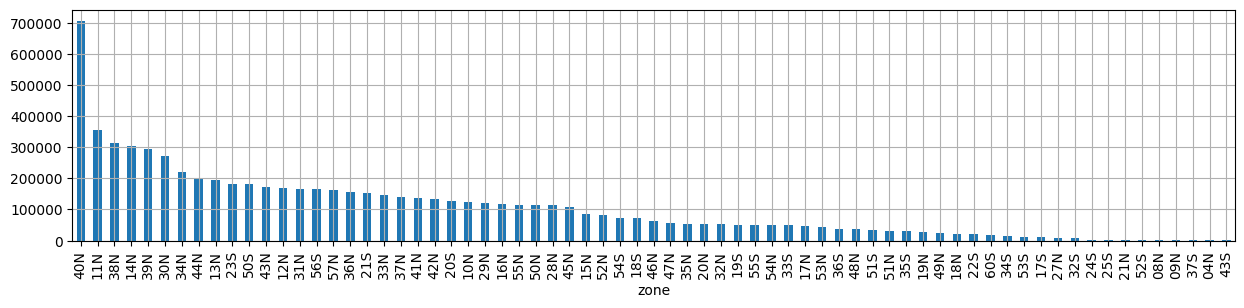

In [62]:
import matplotlib.pyplot as plt

# plot histogram with number of images per zone
fig = plt.figure(figsize=(15, 3))
gdf['zone'].value_counts().plot(kind='bar', ax=fig.gca(), grid=True)
plt.show()


In [63]:
len(gdf['zone'].unique()), len(gdf['region'].unique())

(69, 2967002)

In [64]:
gdf['zone'].value_counts().min()

np.int64(1126)

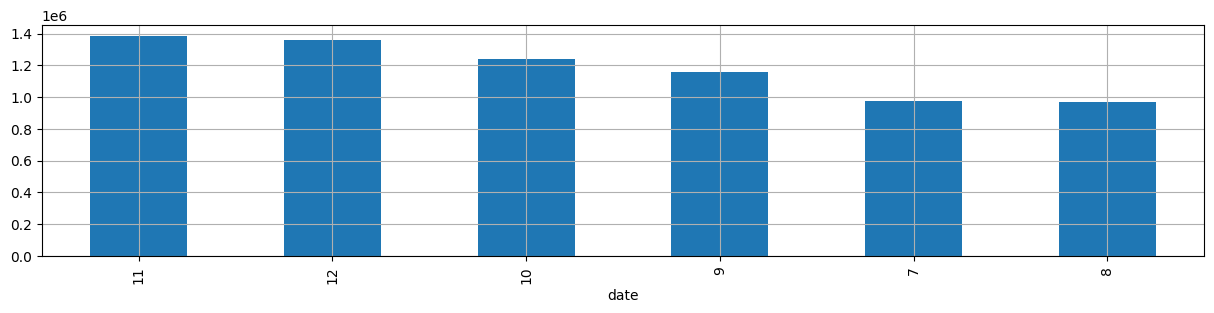

In [65]:
# plot histogram with number of images per month (all images are from 2022)
fig = plt.figure(figsize=(15, 3))
gdf['date'].dt.month.value_counts().plot(kind='bar', ax=fig.gca(), grid=True)
plt.show()


In [66]:
sample = gdf.sample(5, random_state=42)
sample

,json_path,zone,region,date,geometry
4884232,data/json/zone=40N/region=357629_2284200/date=...,40N,357629_2284200,2022-11-29,"POLYGON ((55.63707 20.64826, 55.63704 20.65173..."
4765404,data/json/zone=40N/region=326763_2784655/date=...,40N,326763_2784655,2022-09-10,"POLYGON ((55.28493 25.16457, 55.28488 25.16804..."
1697143,data/json/zone=20S/region=540228_5913815/date=...,20S,540228_5913815,2022-11-03,"POLYGON ((-62.54402 -36.92427, -62.54404 -36.9..."
5606543,data/json/zone=44N/region=434560_3694157/date=...,44N,434560_3694157,2022-12-14,"POLYGON ((80.30057 33.38126, 80.30054 33.38472..."
6888021,data/json/zone=56S/region=333094_6250849/date=...,56S,333094_6250849,2022-10-29,"POLYGON ((151.19958 -33.87302, 151.19966 -33.8..."


Download the images

In [105]:
!rm -rf data/tifs/satellogic
!mkdir -p data/tifs/satellogic
!rm -rf data/tifs/sentinel2
!mkdir -p data/tifs/sentinel2

In [68]:
import json

images = []
for _, item in sample.iterrows():
	json_path = item.json_path
	with open(json_path, 'r') as f:
		metadata = json.load(f)
	asset = metadata['assets']['analytic']['href']
	asset = asset.replace('https://satellogic-earthview.s3.us-west-2.amazonaws.com/', 's3://satellogic-earthview/')
	!s5cmd -endpoint-url https://s3.us-west-2.amazonaws.com --no-sign-request cp {asset} data/tifs/satellogic > /dev/null 2>&1
	images.append(asset.split('/')[-1])

len(images)


5

In [69]:
import os

images = sample.json_path.str.split('/').str[-1].tolist()
images = [i.replace('_metadata.json', '_TOA.tif') for i in images]
for image in images:
	assert image in os.listdir('data/tifs/satellogic')

len(images)

5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.516..1.62].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.516..1.62].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5256666666666666..1.647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5256666666666666..1.647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.4273333333333333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5256666666666666..1.647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.516..1.62].


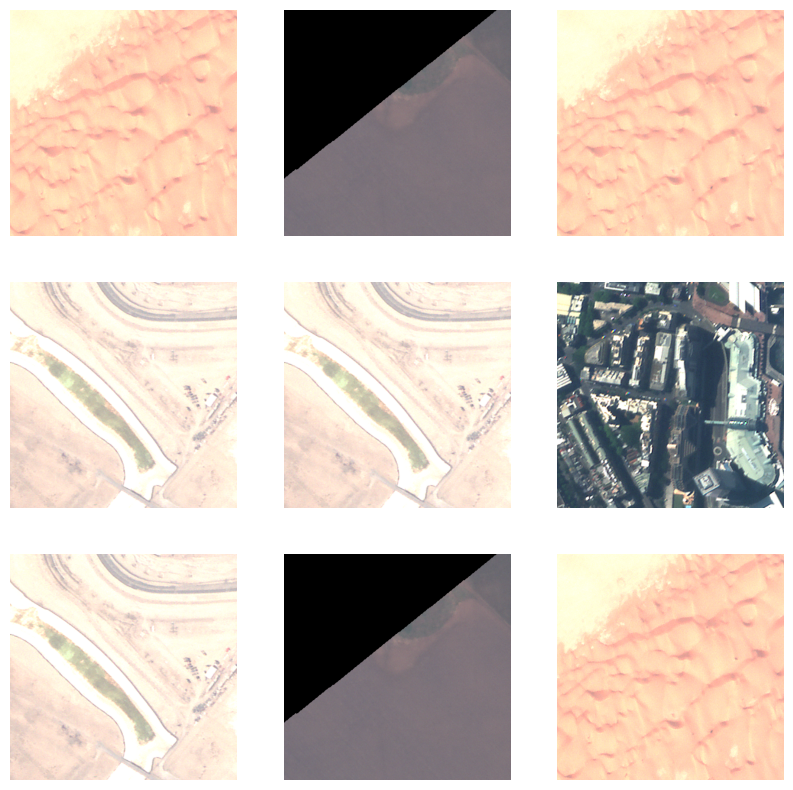

In [70]:
# plot random images

import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
n = 3
fig, axs = plt.subplots(n, n, figsize=(10, 10))
for ax in axs.flatten():
	x = rio.open(f'data/tifs/satellogic/{np.random.choice(images)}').read()
	ax.imshow(x[:3,...].transpose(1, 2, 0) / 3000)
	ax.axis('off')
plt.show()


In [71]:
x.shape, x.dtype, x.min(), x.max()

((4, 384, 384), dtype('uint16'), np.uint16(1548), np.uint16(6488))

In [72]:
from eotdl.access import SUPPORTED_SENSORS

SUPPORTED_SENSORS

('sentinel-1-grd', 'sentinel-2-l1c', 'sentinel-2-l2a', 'dem')

In [95]:
from eotdl.access import search_sentinel_imagery
from datetime import datetime, timedelta

matches = []
time_buffer = 5 # days
for item in sample.itertuples():
	date = item.date
	dates = [(date - timedelta(days=time_buffer/2)).strftime('%Y-%m-%d'), (date + timedelta(days=time_buffer/2)).strftime('%Y-%m-%d')]
	# print(date, dates)
	bb = item.geometry.bounds
	bb = [bb[0], bb[1], bb[2], bb[3]]
	r = search_sentinel_imagery(dates, bb, 'sentinel-2-l2a')
	# matches.append(list(r)[0] if len(list(r)) > 0 else None) # keep first match
	# matches.append(list(r))
	matches = list(r)

matches

[{'id': 'S2B_MSIL2A_20221031T000219_N0400_R030_T56HLH_20221031T013205',
  'properties': {'datetime': '2022-10-31T00:06:06Z', 'eo:cloud_cover': 88.12}},
 {'id': 'S2B_MSIL2A_20221027T235229_N0400_R130_T56HLH_20221028T011729',
  'properties': {'datetime': '2022-10-27T23:56:11Z', 'eo:cloud_cover': 3.34}},
 {'id': 'S2A_MSIL2A_20221026T000221_N0400_R030_T56HLH_20221026T024654',
  'properties': {'datetime': '2022-10-26T00:06:11Z', 'eo:cloud_cover': 34.29}}]

In [96]:
matches.sort(key=lambda x: x['properties']['eo:cloud_cover'])
matches

[{'id': 'S2B_MSIL2A_20221027T235229_N0400_R130_T56HLH_20221028T011729',
  'properties': {'datetime': '2022-10-27T23:56:11Z', 'eo:cloud_cover': 3.34}},
 {'id': 'S2A_MSIL2A_20221026T000221_N0400_R030_T56HLH_20221026T024654',
  'properties': {'datetime': '2022-10-26T00:06:11Z', 'eo:cloud_cover': 34.29}},
 {'id': 'S2B_MSIL2A_20221031T000219_N0400_R030_T56HLH_20221031T013205',
  'properties': {'datetime': '2022-10-31T00:06:06Z', 'eo:cloud_cover': 88.12}}]

In [97]:
matches = [r for r in matches if r['properties']['eo:cloud_cover'] <= 40]
matches

[{'id': 'S2B_MSIL2A_20221027T235229_N0400_R130_T56HLH_20221028T011729',
  'properties': {'datetime': '2022-10-27T23:56:11Z', 'eo:cloud_cover': 3.34}},
 {'id': 'S2A_MSIL2A_20221026T000221_N0400_R030_T56HLH_20221026T024654',
  'properties': {'datetime': '2022-10-26T00:06:11Z', 'eo:cloud_cover': 34.29}}]

In [98]:
closest_match = min(matches, key=lambda x: abs(datetime.fromisoformat(x['properties']['datetime'].replace('Z','')) - date))
closest_match

{'id': 'S2B_MSIL2A_20221027T235229_N0400_R130_T56HLH_20221028T011729',
 'properties': {'datetime': '2022-10-27T23:56:11Z', 'eo:cloud_cover': 3.34}}

In [99]:
date

Timestamp('2022-10-29 00:00:00')

In [26]:
matches[0]

{'id': 'S2B_MSIL2A_20221129T065229_N0400_R020_T40QCH_20221129T082243',
 'properties': {'datetime': '2022-11-29T07:03:51Z', 'eo:cloud_cover': 0.0}}

In [100]:
!rm -rf data/tifs/sentinel2

In [41]:
from eotdl.tools import bbox_from_centroid
from eotdl.access import download_sentinel_imagery

WIDTH = 38
HEIGHT = 38

s2_paths = []
for item, match in zip(sample.itertuples(), matches):
	if not match:
		s2_paths.append(None)
		continue
	centroid = item.geometry.centroid
	# custom_bbox = bbox_from_centroid(x=centroid.x, y=centroid.y, pixel_size=10, width=WIDTH, height=HEIGHT)
	custom_bbox = bbox_from_centroid(x=centroid.y, y=centroid.x, pixel_size=10, width=WIDTH, height=HEIGHT)
	date = match['properties']['datetime']
	# name = f"s2_{item.region}_{item.zone}"
	name = item.json_path.split('/')[-1].replace('_metadata.json', '_S2L2A')

	# print(item.geometry.bounds, custom_bbox)
	download_sentinel_imagery("data/tifs/sentinel2", date, custom_bbox, "sentinel-2-l2a", name=name)
	s2_paths.append(f"data/tifs/sentinel2/{name}.tif")

s2_paths


['data/tifs/sentinel2/20221129_094555_SN31_40N_357629_2284200_S2L2A.tif',
 'data/tifs/sentinel2/20220910_092945_SN28_40N_326763_2784655_S2L2A.tif',
 'data/tifs/sentinel2/20221103_135757_SN11_20S_540228_5913815_S2L2A.tif',
 'data/tifs/sentinel2/20221214_081020_SN31_44N_434560_3694157_S2L2A.tif',
 'data/tifs/sentinel2/20221029_035337_SN20_56S_333094_6250849_S2L2A.tif']

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


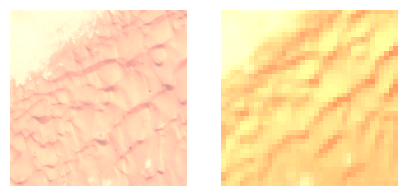

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


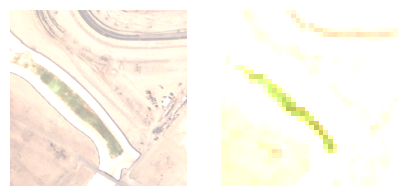

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


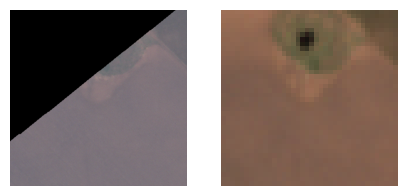

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


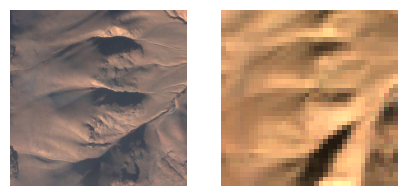

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


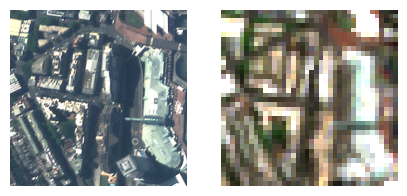

In [29]:
for sat_image, s2_image in zip(images, s2_paths):
	fig, axs = plt.subplots(1, 2, figsize=(5, 3))
	axs[0].imshow((rio.open('data/tifs/satellogic/' + sat_image).read()[:3,...].transpose(1, 2, 0) / 3000).clip(0, 1))
	axs[0].axis('off')
	axs[1].imshow((rio.open(s2_image).read()[(3,2,1),...].transpose(1, 2, 0) / 3000).clip(0, 1))
	axs[1].axis('off')
	plt.show()

